# Shaikat Islam

## Part One: Logistic Regression for Digit Classification
#### Import required libraries.

In [207]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
import scipy

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import stats
from scipy.special import boxcox1p
from scipy.ndimage.filters import gaussian_filter

import seaborn as sns

#### Load the dataset.

In [136]:
x_train = np.loadtxt('./data_digits_8_vs_9_noisy/x_train.csv', delimiter=',', skiprows=1)
x_test = np.loadtxt('./data_digits_8_vs_9_noisy/x_test.csv', delimiter=',', skiprows=1)

In [137]:
y_train = np.loadtxt('./data_digits_8_vs_9_noisy/y_train.csv', delimiter=',', skiprows=1)
y_test = np.loadtxt('./data_digits_8_vs_9_noisy/y_test.csv', delimiter=',', skiprows=1)

### 1.1 Logistic Regression Using Multiple Iterations

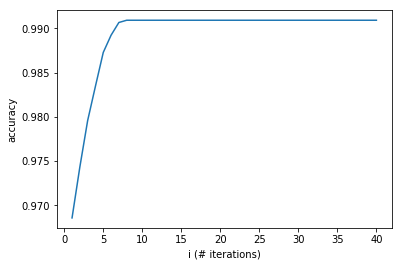

In [230]:

@ignore_warnings(category=ConvergenceWarning)
def log_reg_iterations_vs_accuracy(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_score: 2D list containing an array representing the num of iterations, and another respective
    array representing the score() (accuracy) of the model to be plotted.
    
    '''
    iteration = []
    score_list = []
    iterations_v_score = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        sc = logreg.score(input_set, output_set)
        iteration.append(i)
        score_list.append(sc)
    iterations_v_score.append(iteration)
    iterations_v_score.append(score_list)
    return iterations_v_score

@ignore_warnings(category=ConvergenceWarning)
def log_reg_iterations_vs_logloss(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_score: 2D list containing an array representing the num of iterations, and another respective
    array representing the logloss of the model to be plotted.
    
    '''
    iteration = []
    logloss_list = []
    iterations_v_logloss = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(input_set)
        logloss = log_loss(output_set, prob_float)
        iteration.append(i)
        logloss_list.append(logloss)
    iterations_v_logloss.append(iteration)
    iterations_v_logloss.append(logloss_list)
    return iterations_v_logloss

# # of iterations vs accuracy
iter_v_acc = log_reg_iterations_vs_accuracy(x_train, y_train)

plt.xlabel('i (# iterations)');
plt.ylabel('accuracy');
plt.plot(iter_v_acc[0], iter_v_acc[1]);

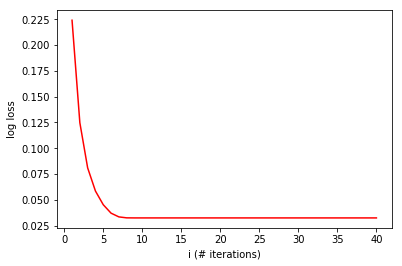

In [17]:
# # of iterations vs log loss

iter_v_logloss = log_reg_iterations_vs_logloss(x_train, y_train)

plt.xlabel('i (# iterations)');
plt.ylabel('log loss');
plt.plot(iter_v_logloss[0], iter_v_logloss[1], color="red");
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## 1.2 Iterations v. Weight

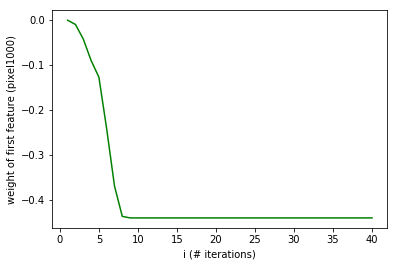

In [21]:
@ignore_warnings(category=ConvergenceWarning)
def log_reg_iterations_vs_initial_weight(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_weight: 2D list containing an array representing the num of iterations, and another respective
    array representing the first weight, that of the feature 'pixel000' in the input data
    
    '''
    iteration = []
    first_weight = []
    iterations_v_firstweight = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        coef = logreg.coef_[0][0]
        iteration.append(i)
        first_weight.append(coef)
    iterations_v_firstweight.append(iteration)
    iterations_v_firstweight.append(first_weight)
    return iterations_v_firstweight

# # of iterations vs first initial feature

iterations_v_firstweight = log_reg_iterations_vs_initial_weight(x_train, y_train)

plt.xlabel('i (# iterations)');
plt.ylabel('weight of first feature (pixel1000)');
plt.plot(iterations_v_firstweight[0], iterations_v_firstweight[1], color="green");

## 1.3 Inverse Penalty and the Best Model

In [190]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

@ignore_warnings(category=ConvergenceWarning)
def log_reg_inverse_penalty(input_set, output_set, test_set, y_true):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature input data representing digits 8 or 9
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    Returns
    -------
    stdout: inverse penalty value that gives least log-loss on test set, accuracy score of the model, and confusion
    matrix
    cm_df: dataframe containing confusion matrix for best model (with greatest accuracy given an inverse penalty value c)
    '''
    C_grid = np.logspace(-9, 6, 31)
    loss_list = []
    c_list = []
    score_list = []
    for c in C_grid:
        logreg = LogisticRegression(C=c, solver='liblinear')
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(test_set)
        logloss = log_loss(y_true, prob_float)
        loss_list.append(logloss)
        c_list.append(c)
        score_list.append(logreg.score(input_set, output_set))
    
    least_log_loss = min(loss_list)
    corresponding_c_val = c_list[loss_list.index(min(loss_list))]
    corresponding_score = score_list[loss_list.index(min(loss_list))]
    
    logreg = LogisticRegression(C=corresponding_c_val, solver='liblinear')
    logreg.fit(input_set, output_set)
    coef = logreg.coef_[0]
    y_pred_actual = logreg.predict(test_set)
    print(y_pred_actual[0])
    
    f_n = []
    f_p = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred_actual[i] and y_true[i] == 0.0:
            f_p.append(np.asarray(input_set[i]))
            
    for i in range(len(y_true)):
        if y_true[i] != y_pred_actual[i] and y_true[i] == 1.0:
            f_n.append(np.asarray(input_set[i]))
            
    f_p = f_p[:9]
    f_n = f_n[:9]
    
    print("The minimum log loss is " + str(least_log_loss) + ".")
    print("The corresponding inverse penalty value is " + str(corresponding_c_val) + ".")
    print("The corresponding accuracy value is " + str(corresponding_score) + ".")  
            
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred_actual)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df, f_p, f_n, coef

    
result_inv_penalty = log_reg_inverse_penalty(x_train, y_train, x_test, y_test)
print(result_inv_penalty[0])

1.0
The minimum log loss is 0.0896895561864.
The corresponding inverse penalty value is 0.0316227766017.
The corresponding accuracy value is 0.980847457627.
Predicted    0    1
True               
0          942   32
1           33  976


## 1.4 Printing False Negatives and False Positives for Best Value of Inverse Penalty On Logistic Regression Models

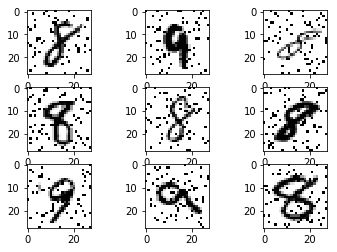

In [191]:
def reshape_arr(arr):
    array = np.zeros([28, 28])
    count  = 0
    for i in range(len(array)):
        for j in range(len(array[i])):
            element = arr[count]
            array[i][j] = element
            count+=1
    return array

def reshape_all(arr):
    ret = []
    for i in arr:
        i = reshape_arr(i)
        ret.append(i)
    return ret

fp_data = reshape_all(result_inv_penalty[1])

# False Positives
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(fp_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(fp_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(fp_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig.add_subplot(3,3,4)
ax4.imshow(fp_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig.add_subplot(3,3,5)
ax5.imshow(fp_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig.add_subplot(3,3,6)
ax6.imshow(fp_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig.add_subplot(3,3,7)
ax7.imshow(fp_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig.add_subplot(3,3,8)
ax8.imshow(fp_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig.add_subplot(3,3,9)
ax9.imshow(fp_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

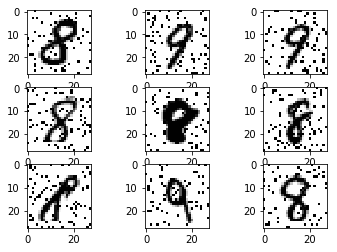

In [192]:
fn_data = reshape_all(result_inv_penalty[2])

# False Negatives
fig1 = plt.figure()
ax1 = fig1.add_subplot(3,3,1)
ax1.imshow(fn_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig1.add_subplot(3,3,2)
ax2.imshow(fn_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig1.add_subplot(3,3,3)
ax3.imshow(fn_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig1.add_subplot(3,3,4)
ax4.imshow(fn_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig1.add_subplot(3,3,5)
ax5.imshow(fn_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig1.add_subplot(3,3,6)
ax6.imshow(fn_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig1.add_subplot(3,3,7)
ax7.imshow(fn_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig1.add_subplot(3,3,8)
ax8.imshow(fn_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig1.add_subplot(3,3,9)
ax9.imshow(fn_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

### 1.5 Plotting Weights of Best Model (Determined by Inverse Penalty) on a 28 x 28 Grid (Dimensions of Images)

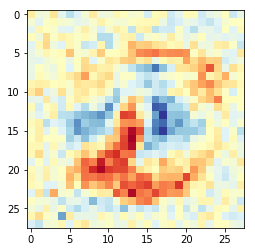

In [195]:
coefficients = result_inv_penalty[3]
coefficients = reshape_arr(coefficients)

# Image Representation of Weights
plt.imshow(coefficients, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

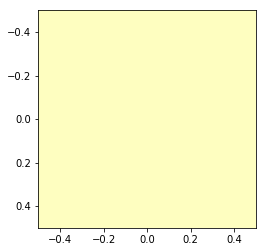

In [200]:
arr = [[0]]
#0.5=blue
#-0.5=red
#0 =yellow
plt.imshow(arr, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

## Part Two: Sneakers v. Sandals

#### Load the dataset.

In [138]:
x_tr_footwear = np.loadtxt('./data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
x_te_footwear = np.loadtxt('./data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)

In [139]:
y_tr_footwear = np.loadtxt('./data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)

### 2.1 - Logistic Regression Model (No parameter tuning or feature augmentation)

In [210]:
%%time
# Write up: What feature transformations tried, and what processes you used to build the classifier
# (parameters that were tried).

# Examples of feature transformations: 
    # - use histograms/parts of the data
    # - consider adding features that count overall number of white or black pixels
    # - consider adding features that capture spacial patterns in original data
    # - data augmentation (flipping data horizontally/vertically)

# Work should contain at least two figures comparing results gotten by doing nothing (just using the original paremeters, no)
# future tuning, and with stuff that I tried.

# Discussion should include error rate on testing data for various models 
    # - each time you run a model, submit the results to the gradescope thing to get an error rate
    
# Error Rate: 0.04249999999999998
# AUROC: 0.9932420000000001
@ignore_warnings(category=ConvergenceWarning)
def logreg_no_tuning(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_no_tuning(x_tr_footwear, y_tr_footwear, x_te_footwear)

Wall time: 1.61 s


### 2.2 - Data Augmentation I: Flipping Images and Multiplying Training Set by 2X

In [211]:
%%time
def add_horizontal_flip_input(input_set):
    result = []
    for element in input_set:
        result.append(element)
    for element in input_set:
        new_element = np.flipud(element) 
        result.append(new_element)
    return np.array(result)

def add_horizontal_flip_output(output_set):
    result = []
    for element in output_set:
        result.append(element)
    for element in output_set:
        result.append(element)
    return np.array(result)
    
x_tr_footwear_h = add_horizontal_flip_input(x_tr_footwear)
y_tr_footwear_h = add_horizontal_flip_output(y_tr_footwear)

# Error Rate: 0.05300000000000005 
# AUROC: 0.98663
def logreg_data_aug_h(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data (flipped) representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_data_aug_h(x_tr_footwear_h, y_tr_footwear_h, x_te_footwear)

Wall time: 4.16 s


### 2.3 - Data Augmentation II: Gaussian Transformation

In [212]:
%%time
def reshape_arr(arr):
    array = np.zeros([28, 28])
    count  = 0
    for i in range(len(array)):
        for j in range(len(array[i])):
            element = arr[count]
            array[i][j] = element
            count+=1
    return array


def gaussian_transform(input_set):
    result = []
    for element in input_set:
        result.append(element)
    for element in input_set:
        new_element = reshape_arr(element)
        gaussian_apply = gaussian_filter(new_element, 784)
        res_element = gaussian_apply.flatten()
        result.append(res_element)
    return np.array(result)

def gaussian_output(output_set):
    result = []
    for element in output_set:
        result.append(element)
    for element in output_set:
        result.append(element)
    return np.array(result)

x_tr_footwear_g = gaussian_transform(x_tr_footwear)
y_tr_footwear_g = gaussian_output(y_tr_footwear)

# Error Rate:  
# AUROC: 
def logreg_data_aug_g(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data (gaussian transformed)
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_data_aug_h(x_tr_footwear_g, y_tr_footwear_g, x_te_footwear)

Wall time: 1min 32s


### 2.4 - Box-Cox Transformation on Input Set

In [213]:
%%time
def box_cox_transform(input_set):
    transformed = boxcox1p(input_set, 0.25)
    return transformed
    
x_tr_footwear_boxcox = box_cox_transform(x_tr_footwear)

# Error Rate: 0.040000000000000036
# AUROC: 0.994132
def logreg_boxcox(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data (normalized using Box-Cox) representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(box_cox_transform(test_set))[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_boxcox(x_tr_footwear_boxcox, y_tr_footwear, x_te_footwear)

Wall time: 1.58 s


### 2.5 - Box-Cox Transformation on Flipped Input Set


In [215]:
%%time
# Error Rate: 0.05449999999999999
# AUROC: 0.988159

x_tr_footwear_h1 = add_horizontal_flip_input(x_tr_footwear)
y_tr_footwear_h1 = add_horizontal_flip_output(y_tr_footwear)

def logreg_boxcox_flipped(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data (normalized using Box-Cox, and flipped) 
    representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(box_cox_transform(test_set))[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_boxcox_flipped(box_cox_transform(x_tr_footwear_h1), y_tr_footwear_h1, x_te_footwear)

Wall time: 4.02 s


### 2.6 - Splitting Test and Train Sets (2:1)

In [216]:
%%time
# Error Rate: 0.03949999999999998
# AUROC: 0.993793
def logreg_split_2_1(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data using 66% of input_set as training data, and the rest of 
    the 33% as the test data
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    test_size = 0.33 #2:1 split
    seed = 7 #for reproducibility
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(input_set, output_set, test_size=test_size, random_state=seed)
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, Y_train)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)
    
logreg_split_2_1(x_tr_footwear, y_tr_footwear, x_te_footwear)

Wall time: 976 ms


### 2.7 - K-Fold Cross Validation

In [228]:
%%time
# Error Rate: 0.04249999999999998
# AUROC: 0.993114
def logreg_k_fold(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data using k-fold cross validation
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    seed = 7 #for reproducibility
    scores = []
    log_reg = LogisticRegression(solver='liblinear')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    for train_index, test_index in kfold.split(input_set):
        X_train, X_test, y_train, y_test = input_set[train_index], input_set[test_index], output_set[train_index], output_set[test_index]
        log_reg.fit(X_train, y_train)    
    prob_float = log_reg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_k_fold(x_tr_footwear, y_tr_footwear, x_te_footwear)

Wall time: 12.5 s


### 2.8 - Parameter Tuning - {"C:1", "multi_class:"ovr", "penalty":"l1"}

In [204]:
#Error: 0.041000000000000036
#AUROC: 0.99336
def logreg_param_tune(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data using the following parameters:
    {"C:1", "multi_class:"ovr", "penalty":"l1"}
    
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    log_reg = LogisticRegression(C=1, multi_class='ovr', penalty='l1')
    log_reg.fit(input_set, output_set)
    prob_float = log_reg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test_param.txt', prob_float)
    
logreg_param_tune(x_tr_footwear, y_tr_footwear, x_te_footwear)

c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
